# Part II

This notebook contains the information considering Part II - analytics of the pubmed and creation of the new dataset. Here we keeps the model and explain the algorithm that we've used to go through all of it

## Table of Contents

   1. [Investigation](#section_1)
   2. [Normalization](#section_2)
   3. [Model training](#section_3)
   4. [Save the results](#section_4)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import json
import csv
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pymed

In [ ]:
from pymed import PubMed
pubmed = PubMed(tool='ehealth_group17', email='huugosimon@gmail.com')
import time

<div id='section_1'></div> 

# Investigation

Investigating which fields are present in the responses

In [ ]:
results = pubmed.query('\"Science in English Class 10\"', max_results=100)
for article in results:
  article = article.toDict()
  print(article.keys())

In [ ]:
read = pd.read_csv('/content/drive/My Drive/EhealthData/g1_f1.csv')
read.head()

,Unnamed: 0,App Name,App Id,Category,Rating,Rating Count,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Description,Installs category,Installs
0,0,Kharty - Study and learn with games,com.kharty.kharty,Education,4.6,782.0,True,0.0,USD,62M,5.0 and up,Kharty LLC,https://www.kharty.com,contact@kharty.com,"Nov 11, 2017","Mar 11, 2021",Everyone,https://www.kharty.com/en/privacy.html,False,False,False,2021-06-16 01:01:11,<h1> 📲 Discover Kharty</h1>\r\nLearning is fun...,"50,000+",50001
1,1,Robocar Poli – New Adventures,com.taptaptales.robocarpoli,Educational,4.3,84.0,True,0.0,USD,66M,4.4 and up,TapTapTales,http://www.taptaptales.com,hello@taptaptales.com,"Mar 29, 2021","Apr 28, 2021",Everyone,http://www.taptaptales.com/privacy-policy-old/,True,True,False,2021-06-16 02:38:47,In Brooms Town every day there’s a new adventu...,"50,000+",50002
2,2,100 Animals and Birds Names for kids,com.hiegames.animalsforkids,Educational,4.3,92.0,True,0.0,USD,19M,4.1 and up,Hiegames.com,NaN,hiegamesofficial@gmail.com,"Oct 12, 2017","Dec 03, 2020",Everyone,https://hiegamesofficial.wordpress.com/privacy...,True,True,False,2021-06-16 03:43:28,Animals for Toddlers and Kids. Learn all anima...,"50,000+",50032
3,3,Learning Numbers for Kids,com.learning.numbers.kids.toddler,Educational,4.3,93.0,True,0.0,USD,18M,4.1 and up,Önder Çağlar,https://ondercaglar.github.io,ondercaglar@gmail.com,"Jul 18, 2016","Jun 17, 2019",Everyone,https://sites.google.com/view/learningnumbersf...,True,False,False,2021-06-15 21:47:25,Learning Numbers for preschoolers is a very si...,"50,000+",50038
4,4,ABC for kids! Alphabet for toddlers! Numbers S...,com.triton_studio.abc.ru,Educational,4.5,84.0,True,0.0,USD,18M,4.0.3 and up,ALEXANDER BABKIN,http://triton-studio.com/,alexander@triton-studio.com,"Apr 8, 2020","Jun 01, 2021",Everyone,https://tritonstudio.github.io/documents/priva...,True,True,False,2021-06-16 02:45:24,<h1>📙 ABC for kids 💯 Numbers for babies ⭐ Sh...,"50,000+",50073


Creating and filling dataset by responses 

In [ ]:
result = pd.DataFrame(columns = ['appnames' , 'pubmed_id','title','keywords','abstract','journal', 'publication_date', 'authors'])

In [ ]:
results = None
for i in range(0,read.shape[0]-1):
    names=read['App Name'][i]
    #print(names)
    articleList = []
    articleInfo = []
    try:
      time.sleep(0.5)
      results = pubmed.query('\"'+names+'\"', max_results=100)
    except:
      time.sleep(5)
      results = pubmed.query('\"'+names+'\"', max_results=100)
    finally:    
      try:
        for article in results:
          articleDict = article.toDict()
          articleList.append(articleDict)
        for article in articleList:
          pubmedId = article['pubmed_id'].partition('\n')[0]
          try:
            keywords = article['keywords']
            result = result.append({'appnames' : names, 'pubmed_id':pubmedId,'title':article['title'],'keywords':article['keywords'],'abstract':article['abstract'],'journal':article['journal'], 'publication_date':article['publication_date'], 'authors':article['authors']}, ignore_index=True )
          except:
            print("--Something went wrong with "+ names)              
      except:
        print("--Problem with iteration on results")
                    
result.to_csv("/content/drive/My Drive/EhealthData/Part21/pubmedAbstract.csv") 
result.head()

In [ ]:
res = pd.read_csv("/content/drive/My Drive/EhealthData/Part21/pubmedAbstract.csv") 
res.shape

(47697, 9)

In [ ]:
res.head(2)

,Unnamed: 0,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors
0,0,Kharty - Study and learn with games,34844694,"The effect of video games, exergames and board...","['Boardgames', 'Early childhood', 'Executive f...",We examined the relation between different kin...,Trends in neuroscience and education,2021-12-01,"[{'lastname': 'Gashaj', 'firstname': 'Venera',..."
1,1,Kharty - Study and learn with games,34831770,Staying Active under Restrictions: Changes in ...,"['coronavirus', 'inactivity', 'lockdown', 'phy...",The COVID-19 pandemic and the associated gover...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Benzing', 'firstname': 'Valenti..."


Checking the data consistency

In [ ]:
print(res[res['authors']=='[]'].shape)
print(res[res['keywords']=='[]'].shape)
print(res[res['journal']=='unknown'].shape) #checked also " " "" "[]" "NaN" "None" "Unknown"
print(res[res['publication_date']==''].shape)
pub_date = res['publication_date'].str.extract(r'(?P<date>[0-9]+-[0-9]+-[0-9]+)') #
pub_date[pub_date['date']=='Nan']

(112, 9)
(18252, 9)
(0, 9)
(0, 9)


,date


Saving only the consistent data

In [ ]:
withoutNone = res[res.keywords != "[]"]
withoutNone = withoutNone[withoutNone.authors != "[]"]
withoutNone.shape

Adding clean lists of keywords of keywords (from provided material)

In [ ]:
meta_list = ["engagement index",
"cross-classification analysis",
"pooled SMD",
"4-level Kirkpatrick model",
"cross-sectional survey",
"metaprop random effects analysis",
"metaprop fix effect analysis",
"meta-analytic review",
"review of published studies",
"meta-ethnography",
"meta-analysis",
"Meta Syntheses",
"Meta Description",
"Meta-",
"Meta-Analyses",
"Meta-Analytic",
"Meta Analyses",
"Meta Analytic",
"Meta-Description",
"Meta-Syntheses",
"Meta-Evaluation",
"Meta Evaluation",
"Meta Analysis",
"Multivariate analysis",
"Hypothesis test",
"Statistical test",
"evaluation study",
"statistical methods",
"synthesize data",
"evaluate data",
"Regression Analysis",
"Cross-classification Analysis",
"Cross-sectional",
"Meta-analytic review",
"Review Of Published Studies",
"Meta-ethnography",
"Meta-analysis",
"Meta-Analysis",
"Meta-analyses",
"Multivariate Analysis",
"Statistics",
"Statistical Test",
"Evaluation Study",
"Statistical Methods",
"Synthesize Data",
"Effect size",
"Exclusion Criteria",
"Meta-regression",
"-- MetaAnalysis --",
"Regression Analysis"]

In [ ]:
rct_list = ["-- RCT --",
"Randomized clinical trial",
"Treatment group",
"Standard group",
"Randomized clinical trial",
"Treatment group",
"Standard group",
"Controlled randomized ",
"-- RCT --",
"Randomized clinical trial ",
"Treatment group",
"Prospective",
"randomized",
"Prospective case series",
"parallel group",
"Standard group",
"Controlled randomized ",
"-- RCT --",
"Randomized clinical trial ",
"Treatment group",
"Standard group",
"Controlled randomized ",
"-- RCT --",
"Randomized clinical trial",
"Treatment group",
"Standard group",
"Controlled randomized ",
"Blinded",
"Controlled trial",
"Random sample",
"Randomize controlled study",
"Control group",
"Randomly assigned ",
"Randomized Controlled Trial",
"Clinical Trial",
"Clinical Trial Phase I",
"Clinical Trial Phase II",
"Clinical Trial Phase III",
"Clinical Trial Phase IV",
"Clinical Trial Protocol",
"Clinical Trial Veterinary",
"Placebo",
"Multicenter Study",
"Expression of Concern",
"Equivalence Trial",
"Controlled Clinical Trial",
"RCT",
"Randomized Control Trial",
"Randomization",
"Randomized Clinical Trial",
"Cluster randomized trial ",
"Randomized controlled",
"random control trial",
"Scientific Experiment",
"Control Trial",
"Control",
"Subgroup Analysis",
"Randomized Trial",
"Randomized Equivalence Trial",
"Clinical Trials",
"Controlled Clinical Trials",
"Control Function",
"Randomized Comparative Trial",
"Randomized Comparison",
"Randomly Assigned",
"Randomized Experiment",
"Pilot Trial",
"Blinded ",
"Controlled trial",
"Random sample ",
"Randomize controlled study",
"Control group",
"Randomly assigned ",
"Randomized Controlled Trial",
"Clinical Trial",
"Clinical Trial Veterinary",
"Placebo",
"Multicenter Study",
"Expression of Concern",
"Equivalence Trial",
"Controlled Clinical Trial",
"RCT",
"Randomized Control Trial",
"Randomization",
"Randomized Clinical Trial",
"Cluster randomized trial ",
"Randomized controlled",
"random control trial",
"Scientific Experiment",
"Control Trial",
"Control",
"Subgroup Analysis",
"Randomized Trial",
"Randomized Equivalence Trial",
"Clinical Trials",
"Controlled Clinical Trials",
"Control Function",
"Randomized Comparative Trial",
"Randomized Comparison",
"Randomly Assigned",
"Randomized Experiment",
"Pilot Trial",
"Controlled randomized ",
"Blinded ",
"Controlled trial",
"Random sample",
"Randomize controlled study",
"Control group",
"Randomly assigned ",
"Randomized Controlled Trial",
"Clinical Trial",
"Clinical Trial Veterinary",
"Placebo",
"Multicenter Study",
"Expression of Concern",
"Equivalence Trial",
"Controlled Clinical Trial",
"RCT",
"Randomized Control Trial",
"Randomization",
"Randomized Clinical Trial",
"Cluster randomized trial",
"Randomized controlled",
"random control trial",
"Scientific Experiment",
"Control Trial",
"Control",
"Subgroup Analysis",
"Randomized Trial",
"Randomized Equivalence Trial",
"Clinical Trials",
"Controlled Clinical Trials",
"Control Function",
"Randomized Comparative Trial",
"Randomized Comparison",
"Randomly Assigned",
"Randomized Experiment",
"Pilot Trial",
"Treatment Group",
"Control Group",
"Standard Group",
"Controlled Randomized",
"Control Trial",
"Control",
"Blinded",
"Blinding",
"Randomized Allocation",
"Controlled Trial",
"Randomized Clinical Trial",
"Random Control Trial",
"Random Sample",
"Randomize Controlled Study",
"Randomly Assigned",
"Randomized Controlled Trial",
"Randomized Control Trial",
"Randomized Comparative Trial",
"Randomized Comparison",
"Randomized Experiment",
"Randomized Trial",
"Randomized Equivalence Trial",
"Cluster Randomized Trial",
"Clinical Trial",
"Clinical Trial Protocol",
"Placebo",
"Multicenter Study",
"Expression Of Concern",
"Equivalence Trial",
"Controlled Clinical Trial",
"RCT",
"Randomization",
"Scientific Experiment",
"Subgroup Analysis",
"Clinical Trials",
"Pilot Trial",
"-- RCT --",
"Randomized clinical trial ",
"Treatment group",
"Standard group",
"Controlled randomized",
"Blinded",
"intervention",
"intervention group",
"intervention groups",
"Controlled trial",
"Random sample ",
"Randomize controlled study",
"Control group",
"control groups",
"Randomly assigned",
"Randomized Controlled Trial",
"Clinical Trial",
"Clinical Trial Veterinary",
"Placebo",
"Multicenter Study",
"Expression of Concern",
"Equivalence Trial",
"Controlled Clinical Trial",
"RCT",
"Randomized Control Trial",
"Randomization",
"Randomized Clinical Trial",
"Cluster randomized trial",
"Randomized controlled",
"random control trial",
"Scientific Experiment",
"Control Trial",
"Subgroup Analysis",
"Randomized Trial",
"Randomized Equivalence Trial",
"Clinical Trials",
"Controlled Clinical Trials",
"Control Function",
"Randomized Comparative Trial",
"Randomized Comparison",
"Randomly Assigned",
"Randomized Experiment",
"Pilot Trial"]

In [ ]:
observstudy_list = ["Validation Studies",
"Retrospective",
"Historical",
"Validation Study",
"Clinical Studies",
"Clinical Study",
"Study Characteristics",
"Pilot Observational Study",
"Mixed-methods Study",
"Clinical Variables",
"Collected Works",
"Collected Work",
"Editorials",
"Editorial",
"Guideline",
"Guidelines",
"Historical Article",
"Historical Articles",
"Journal Article",
"Journal Articles",
"Research Support",
"Technical Report",
"Technical Reports",
"Opinion Paper",
"Opinion Papers",
"Letter",
"Letters",
"Reporting",
"Revision",
"Revisions",
"Personal View",
"Personal Views",
"Multicenter Study",
"Pilot Study",
"Testing Cohorts",
"Training Cohorts",
"Training Cohort",
"Testing Cohort",
"Prospective Study",
"Prospective Mixed-methods Study",
"Prospective Observational Study",
"Evaluation Studies",
"Case Report",
"Case Reports",
"Case Series",
"Case Control Study",
"Cohort Study",
"Cohort Studies",
"Case-control Studies",
"Cross-sectional Studies",
"Comparative Study",
"Cross-sectional Study",
"Cross Sectional Study",
"Cross Sectional Studies",
"Observational Investigation",
"Observational Studies",
"Observational Study",
"Observational Method",
"Observational Research",
"Observational Learning",
"Observational Examination",
"Observational Analysis",
"Observational Review",
"Non Experimental Study",
"Non Experimental Studies",
"Non-Experimental Study",
"Non-Experimental Studies",
"Empirical Study",
"Empirical Studies",
"Empirical Research",
"Empirical Investigation",
"Empirical Method",
"Longitudinal Study",
"Evaluation",
"Questionnaire",
"Interview",
"Experiment",
"Independent Variable",
"Epidemiology",
"Statistics",
"Population",
"Inference",
"Observations",
"Natural Experiment",
"In Vitro Studies",
"Qualitative Evaluation",
"Analytical Observational Studies",
"Descriptive Observational Studies",
"Risk Factor",
"Risk Factors",
"Survey",
"Reports",
"Level Of Evidence III",
"Level Of Evidence IV",
"Reconstructive Analysis",
"-- ObservationalStudy --",
"Validation studies",
"validation study",
"pilot observational study",
"mixed-methods study",
"logistic regression analysis",
"clinical variables",
"collected at baseline",
"developed and validated",
"Collected works",
"Collected work",
"Case report",
"Case reports",
"Historical article",
"Historical articles",
"Journal article",
"Journal articles",
"Research support",
"Technical report",
"Technical reports",
"Opinion paper",
"Opinion papers",
"reporting",
"revision",
"revisions",
"personal view",
"personal views",
"toxicokinetic study",
"pilot study",
"testing cohorts",
"training cohorts",
"training cohort",
"testing cohort",
"prospective study",
"prospective mixed-methods study",
"prospective observational study",
"cohort study",
"cross-sectional study",
"Observational Study Veterinary",
"Case control study",
"Cross sectional study",
"Longitudinal study",
"Mixed-methods study",
"Independent variable",
"social sciences",
"psychology",
"statistics",
"sample",
"population",
"cohort studies",
"case-control studies",
"cross-sectional studies",
"inference",
"observations",
"patient observation",
"animal trial",
"in vitro studies",
"qualitative",
"qualitative evaluation",
"cohort",
"Cohort",
"Cohort study",
"Case Control",
"case control",
"Cases control",
"cases control",
"Cases controls",
"cases controls",
"case series",
"Case-Series",
"case-series",
"Serie",
"Case",
"Scientific Integrity Review",
"Congress",
"Autobiography",
"Biography",
"Case Serie",
"Classical Article",
"Clinical Conference",
"Support of Research",
"Twin Study",
"Validation Studies",
"Consensus Development Conference",
"Consensus Development Conference NIH",
"Government Document",
"Interactive Tutorial",
"Introductory Journal Article",
"Lecture",
"Newspaper Article",
"Patient Education Handout",
"Personal Narrative",
"Practice Guideline",
"Pragmatic Clinical Trial",
"evaluation study",
"comparative studies"]

In [ ]:
sysrev_list = ["-- SystematicReview --",
"reviewed sample",
"Selection criteria",
"review evidence-based algorithms",
"expert-vetted algorithms",
"systematic approach",
"expert-based evaluation",
"systematic instructional design model",
"Systematic searches",
"field study",
"retrospective review",
"evidence-based care guidelines",
"Scientific Integrity Review",
"Support of Research Systematic Review",
"Systematic Literature Review",
"Systematic Scoping Review",
"Systematic Narrative Review",
"Systematic Qualitative Review",
"Systematic Evidence Review",
"Systematic Quantitative Review",
"Systematic Meta-Review",
"Systematic Critical Review",
"Systematic Mixed studies Review",
"Systematic Mapping Review",
"Systematic Cochrane Review",
"Systematic Search and Review",
"Systematic Integrative Review",
"Systematic Review",
"Evaluation Studies",
"Review Systematic",
"Review",
"Literature Review",
"Systematically review",
"Structured review",
"Systematic Search",
"Systematically evaluate",
"review and analysis",
"Reviewed Sample",
"Selection Criteria",
"Systematic Approach",
"Expert-based Evaluation",
"Systematic Searches",
"Scientific Integrity Review",
"Support of Research Systematic Review",
"Systematic Literature Review",
"Systematic Scoping Review",
"Systematic Narrative Review",
"Systematic Qualitative Review",
"Systematic Evidence Review",
"Systematic Quantitative Review",
"Systematic Meta-Review",
"Systematic Critical Review",
"Systematic Mixed Studies Review",
"Systematic Mapping Review",
"Systematic Cochrane Review",
"Systematic Search And Review",
"Systematic Integrative Review",
"Systematic Review",
"Evaluation Studies",
"Review",
"Reviews",
"Reviewed",
"Literature Review",
"Literature Search",
"Structured Review",
"Systematic Search",
"Search Strategy",
"-- SystematicReview --",
"reviewed sample",
"Selection criteria",
"review evidence-based algorithms",
"expert-vetted algorithms",
"systematic approach",
"expert-based evaluation",
"systematic instructional design model",
"Systematic searches",
"field study",
"retrospective review",
"evidence-based care guidelines",
"Scientific Integrity Review",
"Support of Research Systematic Review",
"Systematic Literature Review",
"Systematic Scoping Review",
"Systematic Narrative Review",
"Systematic Qualitative Review",
"Systematic Evidence Review",
"Systematic Quantitative Review",
"Systematic Meta-Review",
"Systematic Critical Review",
"Systematic Mixed studies Review",
"Systematic Mapping Review",
"Systematic Cochrane Review",
"Systematic Search and Review",
"Systematic Integrative Review",
"Systematic Review",
"Evaluation Studies",
"Review Systematic",
"Review",
"Literature Review",
"Systematically review",
"Structured review",
"Systematic Search",
"Systematically evaluate",
"literature",
"review and analysis",
"summary",
"reviewed sample",
"Selection criteria",
"review evidence-based algorithms",
"expert-vetted algorithms",
"systematic approach",
"expert-based evaluation",
"systematic instructional design model",
"Systematic searches",
"field study",
"retrospective review",
"evidence-based care guidelines",
"Scientific Integrity Review",
"Support of Research Systematic Review",
"Systematic Literature Review",
"Systematic Scoping Review",
"Systematic Narrative Review",
"Systematic Qualitative Review",
"Systematic Evidence Review",
"Systematic Quantitative Review",
"Systematic Meta-Review",
"Systematic Critical Review",
"Systematic Mixed studies Review",
"Systematic Mapping Review",
"Systematic Cochrane Review",
"Systematic Search and Review",
"Systematic Integrative Review",
"Systematic Review",
"Evaluation Studies",
"Review Systematic",
"Review",
"Literature Review",
"Systematically review",
"Structured review",
"Systematic Search",
"Systematically evaluate",
"literature",
"review and analysis",
"summary",
"-- SystematicReview --",
"reviewed sample",
"Selection criteria",
"review evidence-based algorithms",
"expert-vetted algorithms",
"systematic approach",
"expert-based evaluation",
"systematic instructional design model",
"Systematic searches",
"field study",
"retrospective review",
"evidence-based care guidelines",
"Scientific Integrity Review",
"Support of Research Systematic Review",
"Systematic Literature Review",
"Systematic Scoping Review",
"Systematic Narrative Review",
"Systematic Qualitative Review",
"Systematic Evidence Review",
"Systematic Quantitative Review",
"Systematic Meta-Review",
"Systematic Critical Review",
"Systematic Mixed studies Review",
"Systematic Mapping Review",
"Systematic Cochrane Review",
"Systematic Search and Review",
"Systematic Integrative Review",
"Systematic Review",
"Evaluation Studies",
"Review Systematic",
"Review",
"Literature Review",
"Systematically review",
"Structured review",
"Systematic Search",
"Systematically evaluate",
"literature",
"review and analysis",
"summary"]

<div id='section_2'></div> 

# Normalization

Normalizing keywords in the dataset and the lists of keywords to make a proper search, next, make a classification by finding class keywords from the lists of keywords in the instances 

In [ ]:
def clean_keywords(s):
  s = s.lower().replace('[','').replace('\n','').replace(']','').replace("\'",'').replace("\"",'').split(', ')
  data = list(dict.fromkeys(s))
  for i in range(len(data)):
    data[i] = re.sub(r'^( )*', '', data[i])
    data[i] = re.sub(r'( )*$', '', data[i])
  return data

def oberlap_dictionary(s, compare):
  empty_list = []
  for i in range(len(compare)):
    compare[i] = compare[i].lower()
  data = list(dict.fromkeys(compare))
  if (list(set(s) & set(compare)) != empty_list):
    return 1
  else:
    return 0

withoutNone['keywords'] = withoutNone['keywords'].apply(clean_keywords)
withoutNone['MetaAnalysis'] = withoutNone['keywords'].apply(oberlap_dictionary,args=(meta_list,))
print(withoutNone[withoutNone['MetaAnalysis'] == 1])

       Unnamed: 0  ... ObservStudy
191           191  ...           0
196           196  ...           0
1612         1612  ...           0
1808         1808  ...           0
1931         1931  ...           0
...           ...  ...         ...
47005       47005  ...           0
47377       47377  ...           0
47506       47506  ...           0
47562       47562  ...           0
47607       47607  ...           0

[204 rows x 13 columns]


In [ ]:
withoutNone['RCT'] = withoutNone['keywords'].apply(oberlap_dictionary,args=(rct_list,))
print(withoutNone[withoutNone['RCT'] == 1])

       Unnamed: 0  ... ObservStudy
61             61  ...           0
405           405  ...           0
522           522  ...           0
597           597  ...           0
608           608  ...           0
...           ...  ...         ...
46705       46705  ...           0
46743       46743  ...           0
46823       46823  ...           0
46918       46918  ...           0
47442       47442  ...           0

[383 rows x 13 columns]


In [ ]:
withoutNone['ObservStudy'] = withoutNone['keywords'].apply(oberlap_dictionary,args=(observstudy_list,))
print(withoutNone[withoutNone['ObservStudy'] == 1])

       Unnamed: 0                             appnames  ...  SysRev ObservStudy
1               1  Kharty - Study and learn with games  ...       0           1
28             28  Kharty - Study and learn with games  ...       0           1
46             46  Kharty - Study and learn with games  ...       0           1
61             61  Kharty - Study and learn with games  ...       0           1
70             70  Kharty - Study and learn with games  ...       0           1
...           ...                                  ...  ...     ...         ...
47508       47508     Learn 33 Languages Free - Mondly  ...       0           1
47518       47518     Learn 33 Languages Free - Mondly  ...       0           1
47596       47596        Peak – Brain Games & Training  ...       0           1
47606       47606                          Math Tricks  ...       0           1
47607       47607                          Math Tricks  ...       0           1

[1074 rows x 13 columns]


In [ ]:
withoutNone['SysRev'] = withoutNone['keywords'].apply(oberlap_dictionary,args=(sysrev_list,))
print(withoutNone[withoutNone['SysRev'] == 1])

       Unnamed: 0                             appnames  ...  SysRev ObservStudy
87             87  Kharty - Study and learn with games  ...       1           0
102           102            Learning Numbers for Kids  ...       1           1
158           158        Biology in Hindi - जीवविज्ञान  ...       1           0
164           164        Biology in Hindi - जीवविज्ञान  ...       1           0
250           250                   English to Kurdish  ...       1           0
...           ...                                  ...  ...     ...         ...
47196       47196                                 NASA  ...       1           0
47396       47396    Wlingua - English Language Course  ...       1           0
47400       47400    Wlingua - English Language Course  ...       1           0
47410       47410    Wlingua - English Language Course  ...       1           0
47435       47435    Wlingua - English Language Course  ...       1           0

[250 rows x 13 columns]


In [ ]:
withoutNone.to_csv('/content/drive/My Drive/EhealthData/Part21/MarkedAbstract.csv')

In [ ]:
withoutNone = pd.read_csv('/content/MarkedAbstract.csv')

In [ ]:
withoutNone.head()


,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy
0,0,0,Kharty - Study and learn with games,34844694,"The effect of video games, exergames and board...","['boardgames', 'early childhood', 'executive f...",We examined the relation between different kin...,Trends in neuroscience and education,2021-12-01,"[{'lastname': 'Gashaj', 'firstname': 'Venera',...",0,0,0,0
1,1,1,Kharty - Study and learn with games,34831770,Staying Active under Restrictions: Changes in ...,"['coronavirus', 'inactivity', 'lockdown', 'phy...",The COVID-19 pandemic and the associated gover...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Benzing', 'firstname': 'Valenti...",0,0,0,1
2,2,2,Kharty - Study and learn with games,34831609,Influence of the Pedagogical Model and Experie...,"['basketball', 'inertial device', 'methodology...",The methodology used by the teacher in Physica...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Gamero', 'firstname': 'María G'...",0,0,0,0
3,3,3,Kharty - Study and learn with games,34813485,Using a 360° Virtual Reality or 2D Video to Le...,"['cognitive load', 'heart rate variability', '...",Learning through a 360° virtual reality (VR) o...,JMIR serious games,2021-11-24,"[{'lastname': 'Chao', 'firstname': 'Yi-Ping', ...",0,0,0,0
4,4,4,Kharty - Study and learn with games,34805978,Toward Automatically Labeling Situations in So...,"['labeling situations', 'soccer', 'sports anal...",We study the automatic annotation of situation...,Frontiers in sports and active living,2021-11-23,"[{'lastname': 'Fassmeyer', 'firstname': 'Denni...",0,0,0,0


In [ ]:
def to_str(abstract):
  return str(abstract)

withoutNone['absract'] = withoutNone['abstract'].apply(to_str)

In [ ]:
withoutNone.shape

(29431, 15)

Starting the analysis of the abstracts of titles, slitting the abstract by words, and making the wordcloud 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


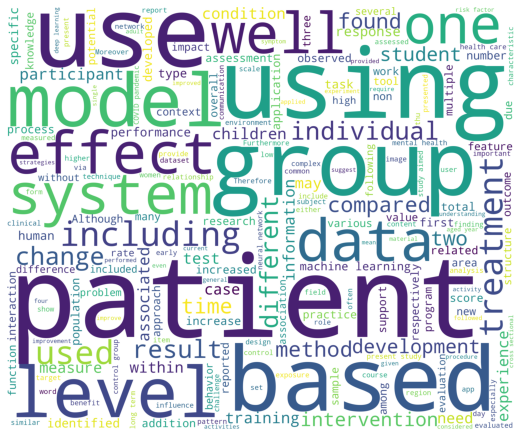

In [ ]:
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Get the list of all words in the corpus
def get_corpus(data):
    corpus = []
    for phrase in data:
      try:
        for word in phrase.split():
          corpus.append(word)
      except:
        continue
    return corpus

# Get the word Cloud
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(withoutNone['abstract'])
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
wordfreq  = procWordCloud.words_
wordfreq

Title cleaning 

In [ ]:
withoutNone['abstract'].head()

0    We examined the relation between different kin...
1    The COVID-19 pandemic and the associated gover...
2    The methodology used by the teacher in Physica...
3    Learning through a 360° virtual reality (VR) o...
4    We study the automatic annotation of situation...
Name: abstract, dtype: object

Normalizing the abstract (removing stopwords and punctuation, tokenization)

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
stopwords = stopwords.words("english")

# Removing punctuation signs from abstract
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ',
             40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 
             60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

withoutNone['abstract_clean'] = withoutNone['abstract'].map(lambda x: to_str(x).lower())
withoutNone['abstract_clean'] = withoutNone['abstract_clean'].map(lambda x: remove_punct(x))
withoutNone['abstract_clean'] = withoutNone['abstract_clean'].map(lambda x: x.split(' '))
withoutNone['abstract_clean'] = withoutNone['abstract_clean'].map(lambda x: [token for token in x if token not in stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
withoutNone['abstract_clean'] = withoutNone['abstract_clean'].map(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus = get_corpus(withoutNone['abstract_clean'])
procWordCloud1 = get_wordCloud(corpus)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


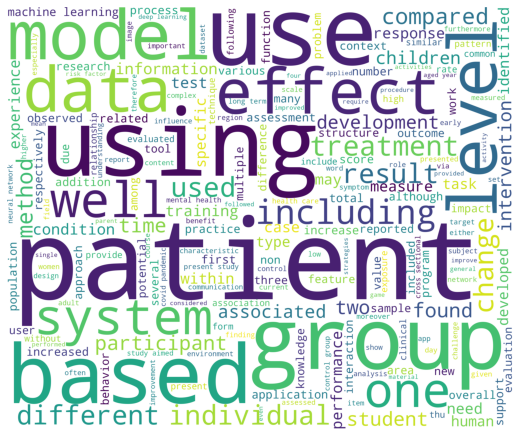

In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud1)
plt.axis('off')
plt.subplot(1, 2, 1)

Making the dataset for models training from classified instances

In [ ]:
withoutNone[((withoutNone['MetaAnalysis'] == 1) | (withoutNone['ObservStudy'] == 1)|(withoutNone['RCT'] == 1)|(withoutNone['SysRev'] == 1 ))].shape

(1791, 16)

In [ ]:
examples  = withoutNone[((withoutNone['MetaAnalysis'] == 1) | (withoutNone['ObservStudy'] == 1)|(withoutNone['RCT'] == 1)|(withoutNone['SysRev'] == 1 ))]

Making hew column class where 1 = observStudy, 2 = RCT, 3 = SysRev, 4 = MetaAnalysis

In [ ]:
examples.to_csv('/content/drive/MyDrive/EHealthData/TrainTestAbstract.csv')
examples.head()

,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy,absract,abstract_clean
1,1,1,Kharty - Study and learn with games,34831770,Staying Active under Restrictions: Changes in ...,"['coronavirus', 'inactivity', 'lockdown', 'phy...",The COVID-19 pandemic and the associated gover...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Benzing', 'firstname': 'Valenti...",0,0,0,1,The COVID-19 pandemic and the associated gover...,covid 19 pandemic associated governmental rest...
19,28,28,Kharty - Study and learn with games,34623315,Effectiveness and Utility of Virtual Reality S...,"['covid-19', 'ppe', 'vr', 'diagnostic', 'effec...",Although the proper use of hygiene and persona...,JMIR serious games,2021-10-09,"[{'lastname': 'Birrenbach', 'firstname': 'Tanj...",0,0,0,1,Although the proper use of hygiene and persona...,although proper use hygiene personal protectiv...
35,46,46,Kharty - Study and learn with games,34489794,Extrinsically Integrated Instructional Quizzes...,"['educational games', 'experiment', 'extrinsic...",Instructional quizzes are frequently used in e...,Frontiers in psychology,2021-09-08,"[{'lastname': 'Jičínská', 'firstname': 'Lucie'...",0,0,0,1,Instructional quizzes are frequently used in e...,instructional quizzes frequently used educatio...
48,61,61,Kharty - Study and learn with games,34383662,Feasibility and Effects of Virtual Reality Mot...,"['vr', 'cognitive frailty', 'feasibility', 'fr...",Cognitive frailty refers to the coexistence of...,JMIR serious games,2021-08-13,"[{'lastname': 'Kwan', 'firstname': 'Rick Yiu C...",0,1,0,1,Cognitive frailty refers to the coexistence of...,cognitive frailty refers coexistence physical ...
55,70,70,Kharty - Study and learn with games,34319237,Medical Students' Perceptions of Play and Lear...,"['computers', 'focus group', 'game-based learn...",In times where distance learning is becoming t...,JMIR serious games,2021-07-29,"[{'lastname': 'Van Gaalen', 'firstname': 'A E ...",0,0,0,1,In times where distance learning is becoming t...,times distance learning becoming norm game bas...


In [ ]:
examples['class'] = 0
examples['class'].loc[examples['ObservStudy'] == 1] = '1'
examples['class'].loc[examples['RCT'] == 1] = '2'
examples['class'].loc[examples['SysRev'] == 1] = '3'
examples['class'].loc[examples['MetaAnalysis'] == 1] = '4'

In [ ]:
examples.dtypes

Unnamed: 0           int64
Unnamed: 0.1         int64
appnames            object
pubmed_id            int64
title               object
keywords            object
abstract            object
journal             object
publication_date    object
authors             object
MetaAnalysis         int64
RCT                  int64
SysRev               int64
ObservStudy          int64
absract             object
abstract_clean      object
class               object
dtype: object

<div id='section_3'></div> 

# Model training


Making the train and the validation datasets

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(examples['abstract_clean'], examples['class'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Making pipelines for SGDClassifier, RandomForestClassifier,KNeighborsClassifier and choosing the best

In [ ]:
sgd_ppl_clf_abstract = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knb_ppl_clf_abstract = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
rf_ppl_clf_abstract = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('RFC_clf', RandomForestClassifier(max_depth=7, random_state=0))])
sgd_ppl_clf_abstract.fit(X_train, y_train)
knb_ppl_clf_abstract.fit(X_train, y_train)
rf_ppl_clf_abstract.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('RFC_clf',
                 RandomForestClassifier(max_depth=7, random_state=0))])

In [ ]:
predicted_sgd = sgd_ppl_clf_abstract.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           1       0.95      0.81      0.87       219
           2       0.69      0.84      0.76        58
           3       0.55      0.75      0.63        24
           4       0.55      0.82      0.65        22

    accuracy                           0.81       323
   macro avg       0.68      0.81      0.73       323
weighted avg       0.85      0.81      0.82       323



In [ ]:
predicted_knb = knb_ppl_clf_abstract.predict(X_test)
print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

           1       0.88      0.71      0.79       228
           2       0.56      0.65      0.60        62
           3       0.15      0.45      0.23        11
           4       0.24      0.36      0.29        22

    accuracy                           0.67       323
   macro avg       0.46      0.54      0.48       323
weighted avg       0.75      0.67      0.70       323



In [ ]:
predicted_rf = rf_ppl_clf_abstract.predict(X_test)
print(metrics.classification_report(predicted_rf, y_test))

              precision    recall  f1-score   support

           1       1.00      0.62      0.76       301
           2       0.23      1.00      0.37        16
           3       0.00      0.00      0.00         2
           4       0.12      1.00      0.22         4

    accuracy                           0.64       323
   macro avg       0.34      0.65      0.34       323
weighted avg       0.94      0.64      0.73       323



In [ ]:
predicted_sgd = sgd_ppl_clf_abstract.predict(examples['abstract_clean'])
examples['class_abstract'] = predicted_sgd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_mark = withoutNone[((withoutNone['MetaAnalysis'] == 0) & (withoutNone['ObservStudy'] == 0) & (withoutNone['RCT'] == 0) & (withoutNone['SysRev'] == 0))]

Making prediction for not classified values

In [ ]:
predicted_final = knb_ppl_clf_abstract.predict(final_mark['abstract_clean'])
final_mark['class'] = predicted_final
final_mark.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy,absract,abstract_clean,class
0,0,0,Kharty - Study and learn with games,34844694,"The effect of video games, exergames and board...","['boardgames', 'early childhood', 'executive f...",We examined the relation between different kin...,Trends in neuroscience and education,2021-12-01,"[{'lastname': 'Gashaj', 'firstname': 'Venera',...",0,0,0,0,We examined the relation between different kin...,examined relation different kinds play behavio...,2
2,2,2,Kharty - Study and learn with games,34831609,Influence of the Pedagogical Model and Experie...,"['basketball', 'inertial device', 'methodology...",The methodology used by the teacher in Physica...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Gamero', 'firstname': 'María G'...",0,0,0,0,The methodology used by the teacher in Physica...,methodology used teacher physical education se...,1
3,3,3,Kharty - Study and learn with games,34813485,Using a 360° Virtual Reality or 2D Video to Le...,"['cognitive load', 'heart rate variability', '...",Learning through a 360° virtual reality (VR) o...,JMIR serious games,2021-11-24,"[{'lastname': 'Chao', 'firstname': 'Yi-Ping', ...",0,0,0,0,Learning through a 360° virtual reality (VR) o...,learning 360° virtual reality vr 2d video repr...,2
4,4,4,Kharty - Study and learn with games,34805978,Toward Automatically Labeling Situations in So...,"['labeling situations', 'soccer', 'sports anal...",We study the automatic annotation of situation...,Frontiers in sports and active living,2021-11-23,"[{'lastname': 'Fassmeyer', 'firstname': 'Denni...",0,0,0,0,We study the automatic annotation of situation...,study automatic annotation situations soccer g...,3
5,5,5,Kharty - Study and learn with games,34803827,The Role of Dynamic Social Norms in Promoting ...,"['ice hockey', 'internalization', 'psychologic...",Conducted among parents of young ice hockey pl...,Frontiers in psychology,2021-11-23,"[{'lastname': 'Amiot', 'firstname': 'Catherine...",0,0,0,0,Conducted among parents of young ice hockey pl...,conducted among parents young ice hockey playe...,1


In [ ]:
final_mark[final_mark['class'] == '4'].shape

(1278, 17)

In [ ]:
final_mark.to_csv('/content/drive/MyDrive/EHealthData/Evaluated.csv')

In [ ]:
examples.head()

,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy,absract,abstract_clean,class,class_abstract
1,1,1,Kharty - Study and learn with games,34831770,Staying Active under Restrictions: Changes in ...,"['coronavirus', 'inactivity', 'lockdown', 'phy...",The COVID-19 pandemic and the associated gover...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Benzing', 'firstname': 'Valenti...",0,0,0,1,The COVID-19 pandemic and the associated gover...,covid 19 pandemic associated governmental rest...,1,1
19,28,28,Kharty - Study and learn with games,34623315,Effectiveness and Utility of Virtual Reality S...,"['covid-19', 'ppe', 'vr', 'diagnostic', 'effec...",Although the proper use of hygiene and persona...,JMIR serious games,2021-10-09,"[{'lastname': 'Birrenbach', 'firstname': 'Tanj...",0,0,0,1,Although the proper use of hygiene and persona...,although proper use hygiene personal protectiv...,1,1
35,46,46,Kharty - Study and learn with games,34489794,Extrinsically Integrated Instructional Quizzes...,"['educational games', 'experiment', 'extrinsic...",Instructional quizzes are frequently used in e...,Frontiers in psychology,2021-09-08,"[{'lastname': 'Jičínská', 'firstname': 'Lucie'...",0,0,0,1,Instructional quizzes are frequently used in e...,instructional quizzes frequently used educatio...,1,1
48,61,61,Kharty - Study and learn with games,34383662,Feasibility and Effects of Virtual Reality Mot...,"['vr', 'cognitive frailty', 'feasibility', 'fr...",Cognitive frailty refers to the coexistence of...,JMIR serious games,2021-08-13,"[{'lastname': 'Kwan', 'firstname': 'Rick Yiu C...",0,1,0,1,Cognitive frailty refers to the coexistence of...,cognitive frailty refers coexistence physical ...,2,2
55,70,70,Kharty - Study and learn with games,34319237,Medical Students' Perceptions of Play and Lear...,"['computers', 'focus group', 'game-based learn...",In times where distance learning is becoming t...,JMIR serious games,2021-07-29,"[{'lastname': 'Van Gaalen', 'firstname': 'A E ...",0,0,0,1,In times where distance learning is becoming t...,times distance learning becoming norm game bas...,1,1


In [ ]:
CLEANR = re.compile('<.*?>') 
CLEAN_QUOTE = re.compile('$[a-zA-Z]')

In [ ]:
def clean_html(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

In [ ]:
def clean_words(stoka):
  return stoka.replace('[', '').replace(']','').replace('\\', '').replace("\'", "").replace("\`", "")

In [ ]:
def ignore_unicode(string):
  return string.encode('ascii', 'ignore').decode()

In [ ]:
def ignore_strange_quotes(string):
  cleantext = re.sub(CLEAN_QUOTE, '', string)
  return cleantext

In [ ]:
def clean(string):
  res_first = clean_words(string)
  res_sec = clean_html(res_first)
  res_th = ignore_unicode(res_sec)
  res = ignore_strange_quotes(res_th)
  return res

In [ ]:
examples['keywords_s'] = examples['keywords'].apply(clean)

Making the same steps to make model for keywords field

In [ ]:
corpus = get_corpus(examples['keywords_s'])
procWordCloud = get_wordCloud(corpus)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


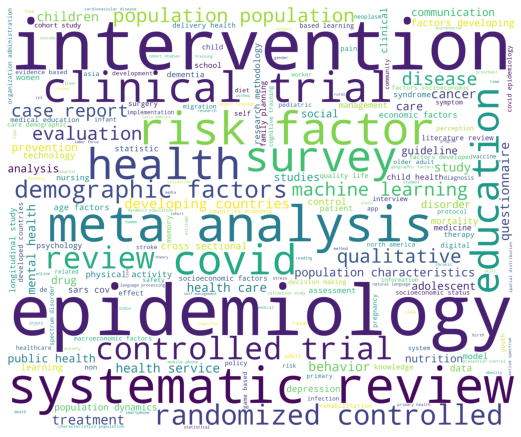

In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(examples['keywords_s'], examples['class'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
examples.shape

(1791, 19)

In [ ]:
sgd_ppl_clf_keyword = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knb_ppl_clf_keyword = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
rf_ppl_clf_keyword = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('RFC_clf', RandomForestClassifier(max_depth=7, random_state=0))])
sgd_ppl_clf_keyword.fit(X_train, y_train)
knb_ppl_clf_keyword.fit(X_train, y_train)
rf_ppl_clf_keyword.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('RFC_clf',
                 RandomForestClassifier(max_depth=7, random_state=0))])

In [ ]:
predicted_rf = rf_ppl_clf_keyword.predict(X_test)
print(metrics.classification_report(predicted_rf, y_test))

              precision    recall  f1-score   support

           1       1.00      0.61      0.75       307
           2       0.23      1.00      0.37        16
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.63       323
   macro avg       0.31      0.40      0.28       323
weighted avg       0.96      0.63      0.74       323



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predicted_knb = knb_ppl_clf_keyword.predict(X_test)
print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

           1       0.90      0.76      0.83       221
           2       0.65      0.77      0.70        60
           3       0.33      0.65      0.44        17
           4       0.58      0.76      0.66        25

    accuracy                           0.76       323
   macro avg       0.62      0.73      0.66       323
weighted avg       0.80      0.76      0.77       323



In [ ]:
predicted_sgd = sgd_ppl_clf_keyword.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           1       1.00      0.97      0.99       191
           2       0.99      0.99      0.99        71
           3       0.91      1.00      0.95        30
           4       0.91      0.97      0.94        31

    accuracy                           0.98       323
   macro avg       0.95      0.98      0.97       323
weighted avg       0.98      0.98      0.98       323



In [ ]:
examples.head()

,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy,absract,abstract_clean,class,class_abstract,keywords_s
1,1,1,Kharty - Study and learn with games,34831770,Staying Active under Restrictions: Changes in ...,"['coronavirus', 'inactivity', 'lockdown', 'phy...",The COVID-19 pandemic and the associated gover...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Benzing', 'firstname': 'Valenti...",0,0,0,1,The COVID-19 pandemic and the associated gover...,covid 19 pandemic associated governmental rest...,1,1,"coronavirus, inactivity, lockdown, physical ac..."
19,28,28,Kharty - Study and learn with games,34623315,Effectiveness and Utility of Virtual Reality S...,"['covid-19', 'ppe', 'vr', 'diagnostic', 'effec...",Although the proper use of hygiene and persona...,JMIR serious games,2021-10-09,"[{'lastname': 'Birrenbach', 'firstname': 'Tanj...",0,0,0,1,Although the proper use of hygiene and persona...,although proper use hygiene personal protectiv...,1,1,"covid-19, ppe, vr, diagnostic, effectiveness, ..."
35,46,46,Kharty - Study and learn with games,34489794,Extrinsically Integrated Instructional Quizzes...,"['educational games', 'experiment', 'extrinsic...",Instructional quizzes are frequently used in e...,Frontiers in psychology,2021-09-08,"[{'lastname': 'Jičínská', 'firstname': 'Lucie'...",0,0,0,1,Instructional quizzes are frequently used in e...,instructional quizzes frequently used educatio...,1,1,"educational games, experiment, extrinsic integ..."
48,61,61,Kharty - Study and learn with games,34383662,Feasibility and Effects of Virtual Reality Mot...,"['vr', 'cognitive frailty', 'feasibility', 'fr...",Cognitive frailty refers to the coexistence of...,JMIR serious games,2021-08-13,"[{'lastname': 'Kwan', 'firstname': 'Rick Yiu C...",0,1,0,1,Cognitive frailty refers to the coexistence of...,cognitive frailty refers coexistence physical ...,2,2,"vr, cognitive frailty, feasibility, frail, gam..."
55,70,70,Kharty - Study and learn with games,34319237,Medical Students' Perceptions of Play and Lear...,"['computers', 'focus group', 'game-based learn...",In times where distance learning is becoming t...,JMIR serious games,2021-07-29,"[{'lastname': 'Van Gaalen', 'firstname': 'A E ...",0,0,0,1,In times where distance learning is becoming t...,times distance learning becoming norm game bas...,1,1,"computers, focus group, game-based learning, g..."


Now we have two values from two classufiers, making an ensemble from them with logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
examples['class_key'] = sgd_ppl_clf_keyword.predict(examples['keywords_s'])
lg_clf = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(examples[['class_key','class_abstract']], examples['class'], test_size=0.2, random_state=42)
lg_clf.fit(X_train,y_train)
pred_lg = lg_clf.predict(X_test)
print(metrics.classification_report(pred_lg, y_test))

              precision    recall  f1-score   support

           1       0.99      0.96      0.97       211
           2       0.95      0.95      0.95        66
           3       0.93      1.00      0.96        40
           4       0.93      0.98      0.95        42

    accuracy                           0.97       359
   macro avg       0.95      0.97      0.96       359
weighted avg       0.97      0.97      0.97       359



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_mark.head()

,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy,absract,abstract_clean,class
0,0,0,Kharty - Study and learn with games,34844694,"The effect of video games, exergames and board...","['boardgames', 'early childhood', 'executive f...",We examined the relation between different kin...,Trends in neuroscience and education,2021-12-01,"[{'lastname': 'Gashaj', 'firstname': 'Venera',...",0,0,0,0,We examined the relation between different kin...,examined relation different kinds play behavio...,2
2,2,2,Kharty - Study and learn with games,34831609,Influence of the Pedagogical Model and Experie...,"['basketball', 'inertial device', 'methodology...",The methodology used by the teacher in Physica...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Gamero', 'firstname': 'María G'...",0,0,0,0,The methodology used by the teacher in Physica...,methodology used teacher physical education se...,1
3,3,3,Kharty - Study and learn with games,34813485,Using a 360° Virtual Reality or 2D Video to Le...,"['cognitive load', 'heart rate variability', '...",Learning through a 360° virtual reality (VR) o...,JMIR serious games,2021-11-24,"[{'lastname': 'Chao', 'firstname': 'Yi-Ping', ...",0,0,0,0,Learning through a 360° virtual reality (VR) o...,learning 360° virtual reality vr 2d video repr...,2
4,4,4,Kharty - Study and learn with games,34805978,Toward Automatically Labeling Situations in So...,"['labeling situations', 'soccer', 'sports anal...",We study the automatic annotation of situation...,Frontiers in sports and active living,2021-11-23,"[{'lastname': 'Fassmeyer', 'firstname': 'Denni...",0,0,0,0,We study the automatic annotation of situation...,study automatic annotation situations soccer g...,3
5,5,5,Kharty - Study and learn with games,34803827,The Role of Dynamic Social Norms in Promoting ...,"['ice hockey', 'internalization', 'psychologic...",Conducted among parents of young ice hockey pl...,Frontiers in psychology,2021-11-23,"[{'lastname': 'Amiot', 'firstname': 'Catherine...",0,0,0,0,Conducted among parents of young ice hockey pl...,conducted among parents young ice hockey playe...,1


In [ ]:
final_mark['keywords_s'] = final_mark['keywords'].apply(clean) 

final_mark['class_abstract'] = sgd_ppl_clf_abstract.predict(final_mark['abstract_clean'])
final_mark['class_key'] = sgd_ppl_clf_keyword.predict(final_mark['keywords_s'])
final_mark['class'] = lg_clf.predict(final_mark[['class_key','class_abstract']])
final_mark.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Unnamed: 0,Unnamed: 0.1,appnames,pubmed_id,title,keywords,abstract,journal,publication_date,authors,MetaAnalysis,RCT,SysRev,ObservStudy,absract,abstract_clean,class,keywords_s,class_abstract,class_key
0,0,0,Kharty - Study and learn with games,34844694,"The effect of video games, exergames and board...","['boardgames', 'early childhood', 'executive f...",We examined the relation between different kin...,Trends in neuroscience and education,2021-12-01,"[{'lastname': 'Gashaj', 'firstname': 'Venera',...",0,0,0,0,We examined the relation between different kin...,examined relation different kinds play behavio...,2,"boardgames, early childhood, executive functio...",2,2
2,2,2,Kharty - Study and learn with games,34831609,Influence of the Pedagogical Model and Experie...,"['basketball', 'inertial device', 'methodology...",The methodology used by the teacher in Physica...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Gamero', 'firstname': 'María G'...",0,0,0,0,The methodology used by the teacher in Physica...,methodology used teacher physical education se...,1,"basketball, inertial device, methodology, phys...",1,1
3,3,3,Kharty - Study and learn with games,34813485,Using a 360° Virtual Reality or 2D Video to Le...,"['cognitive load', 'heart rate variability', '...",Learning through a 360° virtual reality (VR) o...,JMIR serious games,2021-11-24,"[{'lastname': 'Chao', 'firstname': 'Yi-Ping', ...",0,0,0,0,Learning through a 360° virtual reality (VR) o...,learning 360° virtual reality vr 2d video repr...,1,"cognitive load, heart rate variability, learni...",2,1
4,4,4,Kharty - Study and learn with games,34805978,Toward Automatically Labeling Situations in So...,"['labeling situations', 'soccer', 'sports anal...",We study the automatic annotation of situation...,Frontiers in sports and active living,2021-11-23,"[{'lastname': 'Fassmeyer', 'firstname': 'Denni...",0,0,0,0,We study the automatic annotation of situation...,study automatic annotation situations soccer g...,1,"labeling situations, soccer, sports analytics,...",1,1
5,5,5,Kharty - Study and learn with games,34803827,The Role of Dynamic Social Norms in Promoting ...,"['ice hockey', 'internalization', 'psychologic...",Conducted among parents of young ice hockey pl...,Frontiers in psychology,2021-11-23,"[{'lastname': 'Amiot', 'firstname': 'Catherine...",0,0,0,0,Conducted among parents of young ice hockey pl...,conducted among parents young ice hockey playe...,1,"ice hockey, internalization, psychological wel...",1,1


<div id="section 4"></div>

# Save the results

In [ ]:
final_mark.to_csv('/content/drive/MyDrive/EHealthData/FullDatasetLogreg.csv')

In [ ]:
final_mark = final_mark[['appnames',	'pubmed_id'	,'title',	'journal',	'publication_date',	'authors','keywords',	'abstract',	'class'	]]


In [ ]:
examples = examples[['appnames',	'pubmed_id'	,'title',	'journal',	'publication_date',	'authors','keywords',	'abstract',	'class'	]]
frames = [final_mark, examples]
result = pd.concat(frames)
result.to_csv('/content/drive/MyDrive/EHealthData/SiteDataset.csv')

In [ ]:
result['appnames'].unique().shape

(901,)

In [ ]:
dtf = pd.read_csv('/content/drive/MyDrive/EHealthData/SiteDataset.csv')
dtf.head()

,Unnamed: 0,appnames,pubmed_id,title,journal,publication_date,authors,keywords,abstract,class
0,0,Kharty - Study and learn with games,34844694,"The effect of video games, exergames and board...",Trends in neuroscience and education,2021-12-01,"[{'lastname': 'Gashaj', 'firstname': 'Venera',...","['boardgames', 'early childhood', 'executive f...",We examined the relation between different kin...,2
1,2,Kharty - Study and learn with games,34831609,Influence of the Pedagogical Model and Experie...,International journal of environmental researc...,2021-11-28,"[{'lastname': 'Gamero', 'firstname': 'María G'...","['basketball', 'inertial device', 'methodology...",The methodology used by the teacher in Physica...,1
2,3,Kharty - Study and learn with games,34813485,Using a 360° Virtual Reality or 2D Video to Le...,JMIR serious games,2021-11-24,"[{'lastname': 'Chao', 'firstname': 'Yi-Ping', ...","['cognitive load', 'heart rate variability', '...",Learning through a 360° virtual reality (VR) o...,1
3,4,Kharty - Study and learn with games,34805978,Toward Automatically Labeling Situations in So...,Frontiers in sports and active living,2021-11-23,"[{'lastname': 'Fassmeyer', 'firstname': 'Denni...","['labeling situations', 'soccer', 'sports anal...",We study the automatic annotation of situation...,1
4,5,Kharty - Study and learn with games,34803827,The Role of Dynamic Social Norms in Promoting ...,Frontiers in psychology,2021-11-23,"[{'lastname': 'Amiot', 'firstname': 'Catherine...","['ice hockey', 'internalization', 'psychologic...",Conducted among parents of young ice hockey pl...,1
